In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Prepare the Dataset

In [8]:
# Define a transform to normalize the data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Load and partition CIFAR-10 dataset (assumed to be pre-loaded)

def partition_data_iid(dataset, num_clients):
    data_per_client = len(dataset) // num_clients
    indices = np.random.permutation(len(dataset))
    client_data = [indices[i * data_per_client: (i + 1) * data_per_client] for i in range(num_clients)]
    return client_data

def partition_data_non_iid(dataset, num_clients, num_classes=10):
    class_indices = [[] for _ in range(num_classes)]
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    # Shuffle class indices
    for i in range(num_classes):
        np.random.shuffle(class_indices[i])

    client_data = [[] for _ in range(num_clients)]
    classes_per_client = 2  # Each client will get data predominantly from 2 classes

    for client in range(num_clients):
        chosen_classes = np.random.choice(num_classes, classes_per_client, replace=False)
        for cls in chosen_classes:
            data_per_class = len(class_indices[cls]) // (num_clients // classes_per_client)
            client_data[client].extend(class_indices[cls][:data_per_class])
            class_indices[cls] = class_indices[cls][data_per_class:]

    return client_data


# Partition the dataset for IID and Non-IID scenarios
num_clients = 10
iid_client_data = partition_data_iid(trainset, num_clients)
non_iid_client_data = partition_data_non_iid(trainset, num_clients)

In [10]:
from torch.utils.data import DataLoader, Subset

def create_client_dataloaders(dataset, client_data_indices, batch_size=32):
    client_dataloaders = []
    for indices in client_data_indices:
        subset = Subset(dataset, indices)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        client_dataloaders.append(loader)
    return client_dataloaders

# Create DataLoaders for IID and Non-IID partitions
iid_client_dataloaders = create_client_dataloaders(trainset, iid_client_data)
non_iid_client_dataloaders = create_client_dataloaders(trainset, non_iid_client_data)

In [11]:
!pip install torch torchvision

# Define the Model Architecture

In [12]:
#Create a CNN Model:
#Define your CNN model architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(512*2*2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(512)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512*2*2)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Create an instance of the model
model = SimpleCNN()

# Define Train and Evaluate Functions

In [13]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(test_loader.dataset)

# Implement Federated Averaging

In [14]:
# Define Federated Averaging Function

def federated_averaging(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)

# Define Train and Evaluate FedAvg Function
def train_and_evaluate_fedavg(global_model, client_dataloaders, test_loader, num_rounds, epochs_per_round, device):
    client_models = [SimpleCNN().to(device) for _ in range(len(client_dataloaders))]
    accuracies = []
    for round in range(num_rounds):
        for client_idx, client_model in enumerate(client_models):
            client_model.load_state_dict(global_model.state_dict())
            optimizer = optim.SGD(client_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
            criterion = nn.CrossEntropyLoss()
            for epoch in range(epochs_per_round):
                train(client_model, client_dataloaders[client_idx], optimizer, criterion, device)

        federated_averaging(global_model, client_models)
        accuracy = evaluate(global_model, test_loader, device)
        accuracies.append(accuracy)
        print(f'FedAvg - Round {round+1}, Accuracy: {accuracy:.4f}')
    return accuracies


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = SimpleCNN().to(device)
fedavg_accuracies_iid = train_and_evaluate_fedavg(global_model, iid_client_dataloaders, test_loader, num_rounds=200, epochs_per_round=1, device=device)
print("Accuarcy non_iid")
global_model = SimpleCNN().to(device)
fedavg_accuracies_non_iid = train_and_evaluate_fedavg(global_model, non_iid_client_dataloaders, test_loader, num_rounds=200, epochs_per_round=1, device=device)

FedAvg - Round 1, Accuracy: 0.1038
FedAvg - Round 2, Accuracy: 0.3059
FedAvg - Round 3, Accuracy: 0.4518
FedAvg - Round 4, Accuracy: 0.5345
FedAvg - Round 5, Accuracy: 0.5755
FedAvg - Round 6, Accuracy: 0.5938
FedAvg - Round 7, Accuracy: 0.6264
FedAvg - Round 8, Accuracy: 0.6540
FedAvg - Round 9, Accuracy: 0.6758
FedAvg - Round 10, Accuracy: 0.6804
FedAvg - Round 11, Accuracy: 0.7071
FedAvg - Round 12, Accuracy: 0.7157
FedAvg - Round 14, Accuracy: 0.7296
FedAvg - Round 15, Accuracy: 0.7372
FedAvg - Round 16, Accuracy: 0.7492
FedAvg - Round 17, Accuracy: 0.7577
FedAvg - Round 18, Accuracy: 0.7616
FedAvg - Round 19, Accuracy: 0.7684
FedAvg - Round 20, Accuracy: 0.7757
FedAvg - Round 21, Accuracy: 0.7685
FedAvg - Round 22, Accuracy: 0.7843
FedAvg - Round 23, Accuracy: 0.7876
FedAvg - Round 24, Accuracy: 0.7883
FedAvg - Round 25, Accuracy: 0.7923
FedAvg - Round 26, Accuracy: 0.7967
FedAvg - Round 27, Accuracy: 0.7967
FedAvg - Round 28, Accuracy: 0.8029
FedAvg - Round 29, Accuracy: 0.8023
F

# Implement Federated FedProx

In [15]:
# Define Federated FedProx Function
def train_fedprox(model, dataloader, optimizer, criterion, device, global_weights, mu):
    model.train()
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        # FedProx regularization term
        proximal_term = 0.0
        for w, w_global in zip(model.parameters(), global_weights):
            proximal_term += (w - w_global).norm(2)
        loss += (mu / 2) * proximal_term

        loss.backward()
        optimizer.step()

# Define Train and Evaluate FedProx Function
def train_and_evaluate_fedprox(global_model, client_dataloaders, test_loader, num_rounds, epochs_per_round, device, mu):
    client_models = [SimpleCNN().to(device) for _ in range(len(client_dataloaders))]
    accuracies = []
    for round in range(num_rounds):
        global_weights = [param.data.clone() for param in global_model.parameters()]
        for client_idx, client_model in enumerate(client_models):
            client_model.load_state_dict(global_model.state_dict())
            optimizer = optim.SGD(client_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
            criterion = nn.CrossEntropyLoss()
            for epoch in range(epochs_per_round):
                train_fedprox(client_model, client_dataloaders[client_idx], optimizer, criterion, device, global_weights, mu)

        federated_averaging(global_model, client_models)
        accuracy = evaluate(global_model, test_loader, device)
        accuracies.append(accuracy)
        print(f'FedProx - Round {round+1}, Accuracy: {accuracy:.4f}')
    return accuracies

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fedprox_accuracies_iid = train_and_evaluate_fedprox(global_model, iid_client_dataloaders, test_loader, num_rounds=200, epochs_per_round=1, device=device, mu=0.01)
print("Accuracy_non_iid")
global_model = SimpleCNN().to(device)
fedprox_accuracies_non_iid = train_and_evaluate_fedprox(global_model, non_iid_client_dataloaders, test_loader, num_rounds=200, epochs_per_round=1, device=device, mu=0.01)

FedProx - Round 1, Accuracy: 0.7092
FedProx - Round 2, Accuracy: 0.7511
FedProx - Round 3, Accuracy: 0.7606
FedProx - Round 4, Accuracy: 0.7699
FedProx - Round 5, Accuracy: 0.7802
FedProx - Round 6, Accuracy: 0.7900
FedProx - Round 7, Accuracy: 0.7925
FedProx - Round 8, Accuracy: 0.7987
FedProx - Round 9, Accuracy: 0.8009
FedProx - Round 10, Accuracy: 0.8028
FedProx - Round 11, Accuracy: 0.8053
FedProx - Round 12, Accuracy: 0.8088
FedProx - Round 13, Accuracy: 0.8182
FedProx - Round 14, Accuracy: 0.8183
FedProx - Round 15, Accuracy: 0.8204
FedProx - Round 16, Accuracy: 0.8220
FedProx - Round 17, Accuracy: 0.8273
FedProx - Round 18, Accuracy: 0.8250
FedProx - Round 19, Accuracy: 0.8306
FedProx - Round 20, Accuracy: 0.8373
FedProx - Round 21, Accuracy: 0.8350
FedProx - Round 22, Accuracy: 0.8377
FedProx - Round 23, Accuracy: 0.8415
FedProx - Round 24, Accuracy: 0.8388
FedProx - Round 25, Accuracy: 0.8446
FedProx - Round 26, Accuracy: 0.8451
FedProx - Round 27, Accuracy: 0.8441
FedProx - 

# Visualize Results

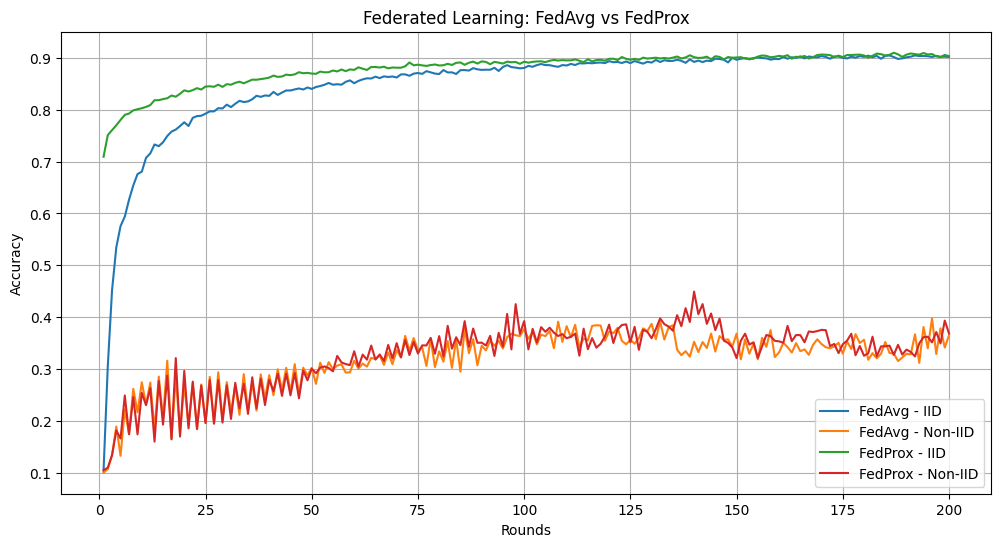

In [17]:
# Adjust rounds based on the length of the accuracy lists
num_rounds = len(fedavg_accuracies_iid)  # Assuming all lists have the same length
rounds = list(range(1, num_rounds + 1))

plt.figure(figsize=(12, 6))
plt.plot(rounds, fedavg_accuracies_iid, label='FedAvg - IID')
plt.plot(rounds, fedavg_accuracies_non_iid, label='FedAvg - Non-IID')
plt.plot(rounds, fedprox_accuracies_iid, label='FedProx - IID')
plt.plot(rounds, fedprox_accuracies_non_iid, label='FedProx - Non-IID')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Federated Learning: FedAvg vs FedProx')
plt.legend()
plt.grid(True)
plt.show()